Path to dataset files: /root/.cache/kagglehub/datasets/codebreaker619/columbia-university-image-library/versions/1


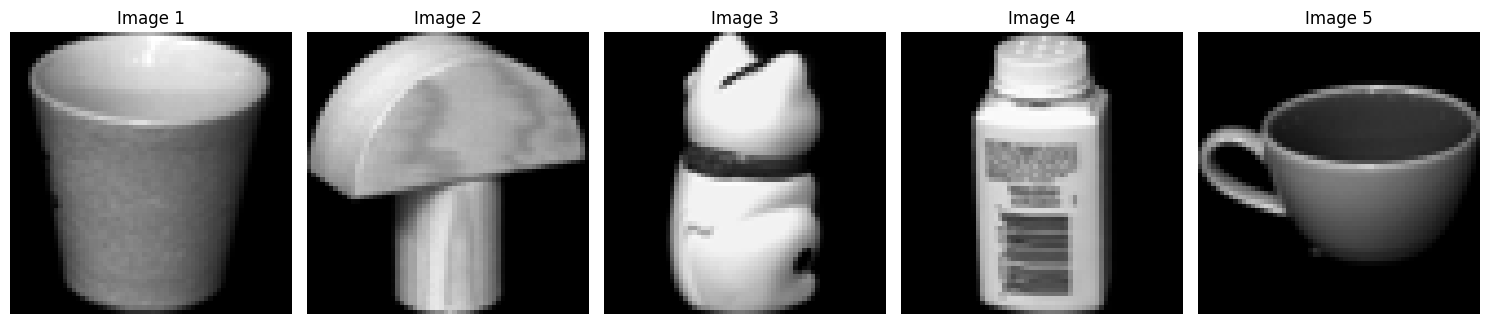

In [9]:
# Import necessary libraries
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
import kagglehub
from PIL import Image

path = kagglehub.dataset_download("codebreaker619/columbia-university-image-library")
print("Path to dataset files:", path)

# Function to load and preprocess images from a specified folder
def load_images_from_folder(folder_path, img_size=(64, 64)):

    images = []

    # Iterate over all files in the specified folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)  # Get the full path of the file

        # Check if the file is an image based on its extension
        if os.path.isfile(file_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = Image.open(file_path).convert("RGB")    # Open the image file and ensure it has 3 color channels (RGB)
            img = img.resize(img_size)                    # Resize the image to the specified dimensions (64 x 64)
            images.append(np.array(img))                  # Convert the PIL Image to a numpy array and add it to the list

    return np.array(images)  # Convert and return the list of images to a numpy array


dataset_path = os.path.join(path, "coil-20", "coil-20-proc")

images = load_images_from_folder(dataset_path)

# Normalize the image pixel values
images = images.astype('float32') / 255.0

# Visualize the first 5 images to verify that they are loaded correctly
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f"Image {i + 1}")
    plt.axis("off")
plt.tight_layout()
plt.show()


In [10]:
# Split dataset into training and testing sets
# 20% of the data will be used for testing
train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

# Model Development
# Encoder
# Input layer: Accepts images of size 64x64 with 3 color channels (RGB)
input_img = Input(shape=(64, 64, 3))
# Convolutional layers: Applies 32/64/128 filters of size 3x3 with ReLU activation
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
# Pooling layers: Downsamples the feature map by a factor of 2 in both dimensions
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
# Deconvolutional layers: Applies 128/64/32 filters of size 3x3 with ReLU activation
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
# Upsampling layers: Upsamples the feature map by a factor of 2
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Combine Encoder and Decoder & compile the autoencoder
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

Epoch 1/20
29/29 [==============================] - 18s 583ms/step - loss: 0.0544 - val_loss: 0.0223
Epoch 2/20
29/29 [==============================] - 16s 572ms/step - loss: 0.0173 - val_loss: 0.0173
Epoch 3/20
29/29 [==============================] - 16s 550ms/step - loss: 0.0142 - val_loss: 0.0117
Epoch 4/20
29/29 [==============================] - 15s 522ms/step - loss: 0.0116 - val_loss: 0.0115
Epoch 5/20
29/29 [==============================] - 15s 518ms/step - loss: 0.0099 - val_loss: 0.0088
Epoch 6/20
29/29 [==============================] - 15s 511ms/step - loss: 0.0082 - val_loss: 0.0076
Epoch 7/20
29/29 [==============================] - 15s 529ms/step - loss: 0.0074 - val_loss: 0.0067
Epoch 8/20
29/29 [==============================] - 15s 511ms/step - loss: 0.0070 - val_loss: 0.0069
Epoch 9/20
29/29 [==============================] - 15s 518ms/step - loss: 0.0064 - val_loss: 0.0061
Epoch 10/20
29/29 [==============================] - 15s 511ms/step - loss: 0.0060 - val_lo

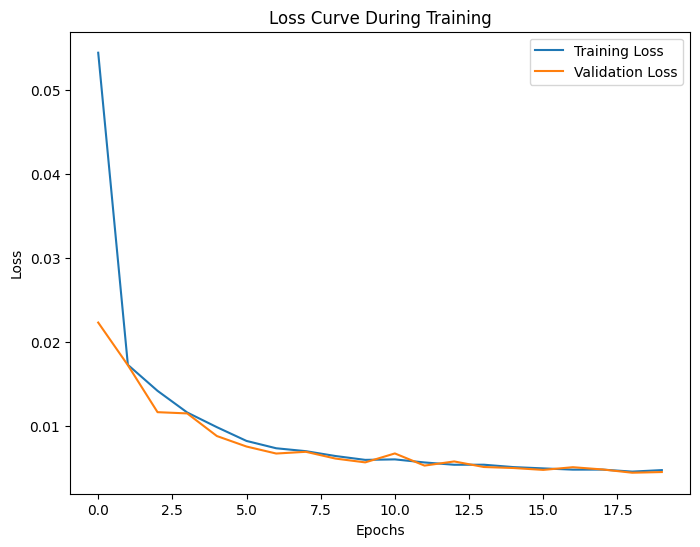

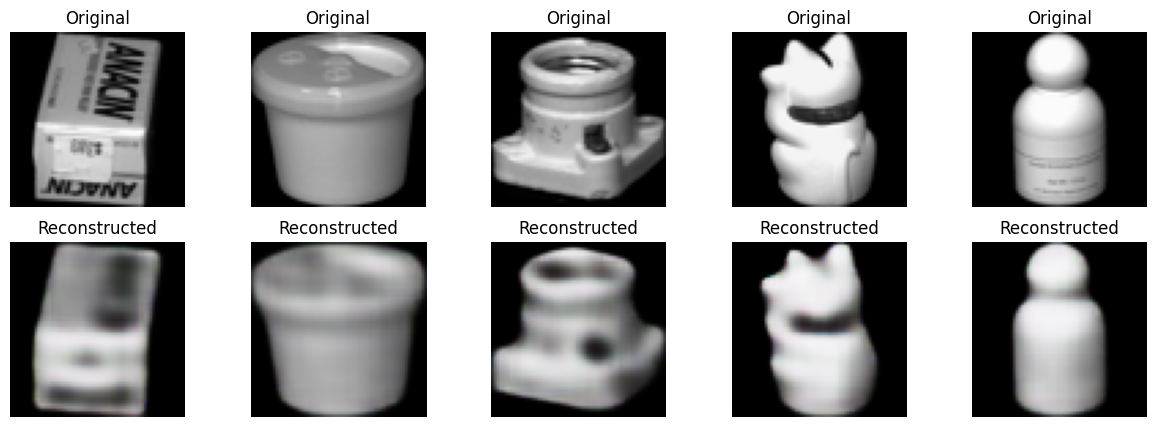

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 128)       7385

In [7]:
# Training

# Define an early stopping callback to prevent overfitting
# Monitors validation loss and stops training if it doesn't improve for 5 consecutive epochs
# Restores the model weights from the epoch with the lowest validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = autoencoder.fit(
    train_images, train_images,
    epochs=20,
    batch_size=32,         # Number of samples processed before updating model weights
    validation_split=0.2,  # Use 20% of the training data for validation
    shuffle=True,          # Shuffle the training data before each epoch
    callbacks=[early_stopping]
)

# Evaluation
test_predictions = autoencoder.predict(test_images)
test_mse = mean_squared_error(test_images.flatten(), test_predictions.flatten())

print(f"Final Test MSE: {test_mse}")

# Visualize loss curve
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve During Training')
plt.show()

# Original vs. Reconstructed Images
def plot_reconstructions(original, reconstructed, n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        # Original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i])
        plt.title("Original")
        plt.axis("off")

        # Reconstructed images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i])
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

plot_reconstructions(test_images, test_predictions)

# Print the architecture of the CNN Autoencoder (all layers, their shapes, and the total number of parameters)
autoencoder.summary()